# SOTA Model: LSTM

### Import Libraries

##### Suppress Warnings

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from keras.utils import to_categorical

import matplotlib.pyplot as plt

import seaborn as sns

## Data

#### Read Whole Data

In [ ]:
dataset = pd.read_csv('Dataset/final_dataset_volume_1.csv')

features = dataset.iloc[:, :-1]
labels = dataset.iloc[:,-1]

#### Prepare/Save Train+Test Data

In [ ]:
n_classes = 9
categorical_labels = to_categorical(labels, num_classes=n_classes, dtype ="int32")

# Reshape the input data into a 3D tensor to use as input for LSTM
n_samples = features.shape[0]
n_timesteps = 15  # flattened 15 rows to one feature
n_features = 75  # 3 sensor readings for each of 25 joints
X = features.values.reshape(n_samples, n_timesteps, n_features)

# split the data into training and testing sets
dr = 'TrainTestData/'

if all(os.path.exists(dr + path) for path in ['X_train_data.npy', 'X_test_data.npy', 'y_train_data.npy', 'y_test_data.npy']):
    print('Loading existing train and test data')
    X_train = np.load(dr + 'X_train_data.npy')
    X_test  = np.load(dr + 'X_test_data.npy')
    y_train = np.load(dr + 'y_train_data.npy')
    y_test  = np.load(dr + 'y_test_data.npy')
else:
    print('Creating new train and test data')
    X_train, X_test, y_train, y_test = train_test_split(X, categorical_labels, test_size=0.2)
    np.save(dr + 'X_train_data.npy', X_train)
    np.save(dr + 'X_test_data.npy' , X_test)
    np.save(dr + 'y_train_data.npy', y_train)
    np.save(dr + 'y_test_data.npy' , y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep='\n')

Loading existing train and test data
(26150, 15, 75)
(6538, 15, 75)
(26150, 9)
(6538, 9)


## Defining LSTM Model

### Load Model (if existent)

In [ ]:
sota_model = None
if os.path.exists('cs3244_project2_lstm_model.h5'):
    # If saved model exists, load model
    print('Loading saved model weights')
    sota_model = tf.keras.models.load_model('cs3244_project2_lstm_model.h5')
    print("Skip to section 'Model Training' or 'Model Prediction'")
else:
    print('No saved model weights found')
    print('Create and train a new LSTM model')

Loading saved model weights
Skip to section 'Model Training' or 'Model Prediction'


### Model Training

In [ ]:
# Train the LSTM model with the best set of hyperparameters found in LSTM_HP_tune.ipynb
LSTM_units, dense_units1, dense_units2 = 512, 512, 256
dropout_rate = 0.2

# Create new LSTM model if none was loaded
if not sota_model:
    sota_model = Sequential()
    # Input layer: LSTM
    sota_model.add(LSTM(
        units=LSTM_units, input_shape=(n_timesteps, n_features),
        dropout=dropout_rate, recurrent_dropout=dropout_rate
    ))
    # Two hidden recurrent layers
    sota_model.add(Dense(units=dense_units1, name='hidden-1', activation='relu'))
    sota_model.add(Dense(units=dense_units2, name='hidden-2', activation='relu'))
    # Output layer
    sota_model.add(Dense(units=n_classes, activation='softmax'))

    sota_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='loss', patience=2, verbose=1), 
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=0.00001, cooldown=2, min_delta=0.001)
]

sota_model.fit(X_train, y_train, epochs=35, batch_size=32, callbacks=callbacks)

Epoch 1/35
818/818 [==============================] - 45s 54ms/step - loss: 0.8107 - accuracy: 0.6883 - lr: 0.0010
Epoch 2/35
818/818 [==============================] - 45s 56ms/step - loss: 0.4374 - accuracy: 0.8344 - lr: 0.0010
Epoch 3/35
818/818 [==============================] - 48s 58ms/step - loss: 0.3526 - accuracy: 0.8689 - lr: 0.0010
Epoch 4/35
818/818 [==============================] - 47s 58ms/step - loss: 0.2809 - accuracy: 0.8930 - lr: 0.0010
Epoch 5/35
818/818 [==============================] - 52s 64ms/step - loss: 0.2577 - accuracy: 0.9047 - lr: 0.0010
Epoch 6/35
818/818 [==============================] - 55s 68ms/step - loss: 0.2278 - accuracy: 0.9158 - lr: 0.0010
Epoch 7/35
818/818 [==============================] - 54s 65ms/step - loss: 0.1964 - accuracy: 0.9269 - lr: 0.0010
Epoch 8/35
818/818 [==============================] - 53s 64ms/step - loss: 0.1842 - accuracy: 0.9316 - lr: 0.0010
Epoch 9/35
818/818 [==============================] - 53s 64ms/step - loss: 0.16

In [ ]:
sota_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 512)               1204224   
                                                                 
 hidden-1 (Dense)            (None, 512)               262656    
                                                                 
 hidden-2 (Dense)            (None, 256)               131328    
                                                                 
 dense_31 (Dense)            (None, 9)                 2313      
                                                                 
Total params: 1,600,521
Trainable params: 1,600,521
Non-trainable params: 0
_________________________________________________________________


### Save Model Weights

In [ ]:
sota_model.save('cs3244_project2_lstm_model.h5')

### Model Prediction

In [ ]:
pred = sota_model.predict(X_test)

205/205 [==============================] - 3s 14ms/step


### Model Accuracy (against Test Data)

In [ ]:
score = sota_model.evaluate(X_test, y_test, verbose=0)
print(f'Model Loss: {score[0]}')
print(f'Model Accuracy: {score[1]}')

Model Loss: 0.045195113867521286
Model Accuracy: 0.9837871193885803


### Other Evaluation Metrics

In [ ]:
# Decode one-hot encoded vectors to a single integer value (i.e., the index)
# e.g., [1, 0, 0, 0, 0] -> [0]
#       [0, 0, 1, 0, 0] -> [2]
pred_1d = tf.argmax(pred, axis=1)
y_test_1d = tf.argmax(y_test, axis=1)

#### Micro-Average

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test_1d, pred_1d, average='micro')
print('Micro-Average Scores:')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'F1       : {f1}')

Micro-Average Scores:
Precision: 0.983787090853472
Recall   : 0.983787090853472
F1       : 0.983787090853472


#### Macro-Average

In [ ]:
# Get scores for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test_1d, pred_1d)
avg = lambda arr: sum(arr) / len(arr)
print('Macro-Average Scores:')
print(f'Precision: {avg(precision)}')
print(f'Recall   : {avg(recall)}')
print(f'F1       : {avg(f1)}\n')

# Show scores for each class as a table
np_metrics = np.column_stack([precision, recall, f1])
pd_metrics = pd.DataFrame(np_metrics, columns=['Precision', 'Recall', 'F1'])
print('Metrics per class')
pd_metrics

Macro-Average Scores:
Precision: 0.9840648440644725
Recall   : 0.9839917294216567
F1       : 0.9839779924807763

Metrics per class


,Precision,Recall,F1
0,0.974768,0.989218,0.981940
1,0.992997,0.977931,0.985407
2,0.970509,0.962766,0.966622
3,0.990210,0.975207,0.982651
4,0.980000,0.983936,0.981964
5,0.979079,0.991525,0.985263
6,1.000000,1.000000,1.000000
7,0.974599,0.998630,0.986468
8,0.994421,0.976712,0.985487


#### Confusion Matrix

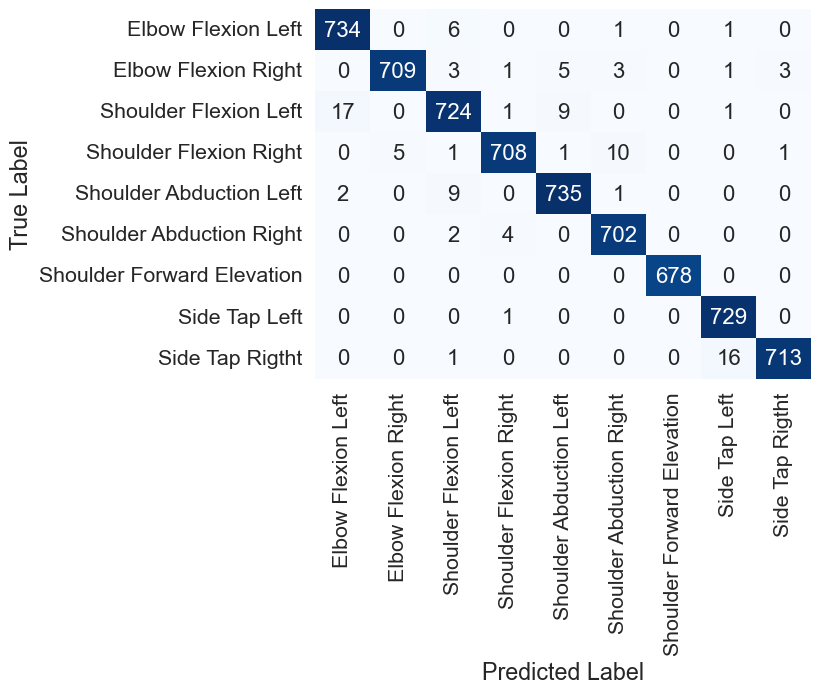

In [ ]:
gestureLabels = ['Elbow Flexion Left', 'Elbow Flexion Right', 'Shoulder Flexion Left', 'Shoulder Flexion Right',
                 'Shoulder Abduction Left', 'Shoulder Abduction Right', 'Shoulder Forward Elevation',
                 'Side Tap Left', 'Side Tap Rigtht']

label_map = {i: label for i, label in enumerate(gestureLabels)}
labels = [label_map[i] for i in range(len(label_map))]

# Create confusion matrix
cm = confusion_matrix(y_test_1d, pred_1d)

# Plot confusion matrix as heatmap
sns.set(font_scale=1.4) # Adjust font size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)

# Set plot labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()